# 13: Sparse Identification of Nonlinear Dynamical systems (SINDy)

**Exercise:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/13-sindy/13-sindy-exercise.ipynb)
**Solution:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/13-sindy/13-sindy.ipynb)

In [ ]:
!pip3 install pysindy --quiet

## Main ideas

SINDy aims to learn nonlinear dynamical systems from data. Suppose we have a set of measurements $u(t)\in \mathbb{R}^n$ from some physical system at different points in time $t$. SINDy seeks to represent the time evolution of $u(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}u(t) = f(u(t)). $$

This equation constitutes a *dynamical system* for the measurements $u(t)$. The vector $u(t)=[u_1(t), u_2(t), \dots u_n(t)]^\top$ gives the state of the physical system at time $t$. The function $f(u(t))$ constrains how the system evolves in time. 

We suppose that $f(u(t))$ is a weighted sum of nonlinear terms, and our goal is to discover which terms make up $f$, and their corresponding weights. 

The key idea behind SINDy is that the function $f$ is often **sparse** in the space (with few terms) of an appropriate set of basis functions, and we can find its terms by enforcing sparsity while performing linear regression. It’s a simple and powerful idea, which we’ll explore in detail. For example, the function

$$
	\frac{d}{dt}u = f(u)
	= \begin{bmatrix} f_1(u)\\f_2(u) \end{bmatrix}
	= \begin{bmatrix}1 - u_1 + 3u_1u_2 \\ u_2^2 - 5u_1^3 \end{bmatrix}
$$

is sparse with respect to the set of polynomials of two variables in the sense that if we were to write an expansion of the component functions of $f$ in this basis (e.g. $f_{1}(u) = \sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}u_1^iu_2^j$), only a small number of coefficients ($a_{i,j}$) would be nonzero.

SINDy employs **sparse regression** to find a linear combination of basis functions that best capture the dynamic behavior of the physical system.

## Linear regression

We’ll take a brief look at linear regression in this section.

The goal of linear regression is to model the relationship between two variables, an $n$-dimensional independent variable and a scalar-valued dependent variable, using a linear equation to relate the two. In machine learning, typically, the $n$-dimensional independent variable consists of the data point’s features, and the scalar-valued dependent variable holds the corresponding target value.

Let’s look at the equation that describes the linear relationship that we would like to establish between these two variables:

$$y = b + X \omega$$

We’ll assume that we have $m$ data points, each with $n$ features, forming the $m \times n$ matrix $X$. We also have a vector $y$ of size $m \times 1$ containing a target associated with each data point. In general, it's impossible to satisfy the above equation exactly. Instead, our goal is to find coefficents for the weight vector $w$ and bias $b$ such that the right-hand-side of the equation (let's call that $\hat{y}$) comes as close as possible to the target $y$. Here, the weight vector $w$ has a size $n \times 1$, the bias vector $b$ is of size $m \times 1$ where the constant bias is repeated $m$ times. 

Visually, if our data points have just one feature (so $X$ has one column), we can think of linear regression as finding a line in 2D that comes closest to passing through all the points $(x_i, y_i)$, where $x_i$ is a row of $X$, and $y_i$ corresponds to the target value. In the diagram below, the orange dots show the target values $y$, and the gray dots show the predictions $\hat{y}$.

![regression](regression.png)

If our data points were two-dimensional, then we would be finding a plane instead of a line. And if they were $n$-dimensional, we would be finding a hyperplane.

In the context of machine learning, it’s common to write the relationship between $X$ and $y$ by incorporating $b$ into the rest of the equation, which avoids the repetition of the constant bias:

$$y = X \xi$$

In this equation, $X$ now has size $m \times (n+1)$, where the entries in the first column are all 1. The unknown vector is now $\xi$, of size $(n + 1) \times 1$, because it contains the value of the constant bias in the first row followed by the values of $w$. The vector $y$ has the same size as before, $m \times 1$, as expected.

In the equation above, the target values $y$ and the features $X$ are known, so our goal is to find the vector $\xi$ that makes the right-hand-side of the equation best approximate the left-hand-side. Problems of this kind are often solved directly using least-squares techniques (like the normal equation), which aim to minimize the square of the distance between the predicted values $\hat{y}$ and target values $y$ — in other words, they minimize the sum of the lengths of the vertical lines in the diagram above. Problems of this kind can also be solved using iterative optimization methods, such as gradient descent, which grant us more freedom in our approach.

Often our goal is not just to get the best $\xi$ — we want the best $\xi$ that is also sparse. Sparsity is a desirable feature in general, and we’ll see later why sparsity is super important in the SINDy scenario in particular. It turns out that there are also several algorithms that help us solve the equation above with sparsity — for example, LASSO (Least Absolute Shrinkage and Selection Operator) is a popular method.

## Approximation problem
To apply SINDy in practice one needs a set of measurement data collected at times $t_1, t_2, \dots, t_n$, and the time derivatives of these measurements (either measured directly or numerically approximated). These data are aggregated into the matrices $U$ and $\dot U$, respectively

$$
	U = \begin{bmatrix}
		u_1(t_1) & u_2(t_1) & \dots & u_n(t_1) \\
		u_1(t_2) & u_2(t_2) & \dots & u_n(t_2) \\
		\vdots & \vdots & & \vdots \\ u_1(t_m) & u_2(t_m) & \dots & u_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{U} = \begin{bmatrix} \dot{u_1}(t_1) & \dot{u_2}(t_1) & \dots & \dot{u_n}(t_1) \\
		\dot{u_1}(t_2) & \dot{u_2}(t_2) & \dots & \dot{u_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{u_1}(t_m) & \dot{u_2}(t_m) & \dots & \dot{u_n}(t_m)
	\end{bmatrix}.
$$

Next, one forms a library matrix $\Theta(U)$ whose columns consist of a chosen set of basis functions applied to the data

$$
	\Theta(U) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(U) & \theta_2(U) & \dots & \theta_\ell(U) \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

For example, if $\theta_1(u), \theta_2(u), \dots, \theta_\ell(u)$ are monomials ($\theta_i(u) = u^{i-1}$), then

$$
	\theta_3(U) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		u_1(t)^2 & u_1(t)u_2(t) & \dots & u_2(t)^2 & u_2(t)u_3(t) & \dots & u_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

where vector products and powers are understood to be element-wise.

We seek a set of sparse coefficient vectors (collected into a matrix)

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

The vector $\xi_i$ provides the coefficients for a linear combination of basis functions $\theta_1(u), \theta_2(u), \dots, \theta_\ell(u)$ representing the $i$th component function of $f$: $f_i(u)$. That is to say, $f_i(u) = \Theta\left(u^\top\right) \xi_i$, where $\Theta\left(u^\top\right)$ is understood to be a row vector consisting of symbolic functions (whereas $\Theta(U)$ is a matrix whose entries are numerical values).

With each of the objects $U$, $\dot U$, $\Theta(U)$, and $\Xi$ being defined, we are ready to write down the approximation problem underlying SINDy:

$$ \dot U \approx \Theta(U)\Xi. $$

## Structure of PySINDy
The submodules of PySINDy are each aligned with one of the terms in the aforementioned approximation equation

$$ \dot X \approx \Theta(X)\Xi. $$

 * `pysindy.differentiate` performs numerical differentiation to compute $\dot X$ from $X$;
 * `pysindy.feature_library` allows the user to specify a set of library functions and handles the formation of $\Theta(X)$;
 * `pysindy.optimizers` provides a set of sparse regression solvers for determining $\Xi$.

The `SINDy` object encapsulates one class object from each of these three submodules and uses them, along with a user-supplied data matrix, to find a governing dynamical system.

Let's walk through an example showing how this works using a toy dataset.

## Example
Suppose we have measurements of the position of a particle obeying the following dynamical system at different points in time:

$$
	\frac{d}{dt} \begin{bmatrix} x \\ y \end{bmatrix}
	= \begin{bmatrix} -2x \\ y \end{bmatrix}
	= \begin{bmatrix} -2 & 0 \\ 0 & 1 \end{bmatrix}
	\begin{bmatrix} x \\ y \end{bmatrix}
$$

Note that this system of differential equations decouples into two differential equations whose solutions are simply $x(t) = x_0e^{-2t}$ and $y(t) = y_0e^t$, where $x_0 = x(0)$ and $y_0=y(0)$ are the initial conditions.

Using the initial conditions $x_0 = 3$ and $y_0 = \tfrac{1}{2}$, we construct the data matrix $X$.

In [17]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt


def gen_data1():
    t = np.linspace(0, 1, 100)
    x = 3 * np.exp(-2 * t)
    y = 0.5 * np.exp(t)
    return t, x, y


def gen_data2():
    x0 = 6
    y0 = -0.1
    t_test = np.linspace(0, 1, 100)
    x_test = x0 * np.exp(-2 * t_test)
    y_test = y0 * np.exp(t_test)
    return x0, y0, t_test, x_test, y_test


In [18]:
t, x, y = gen_data1()
X = np.stack((x, y), axis=-1)  # First column is x, second is y

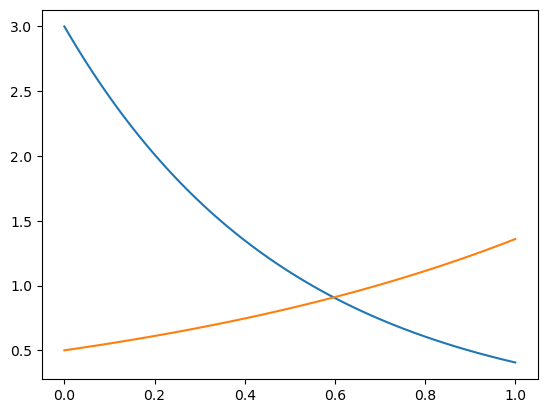

In [19]:
plt.plot(t, x, label="x")
plt.plot(t, y, label="y")

We can select a differentiation method from the `differentiation` submodule.

In [20]:
differentiation_method = ps.FiniteDifference(order=2)

# We could instead call ps.differentiation.FiniteDifference(order=2)

While we could use this method to compute $\dot X$ "by hand," it is often more convenient to pass it into the `SINDy` object and let the computation of $\dot X$ be handled automatically.

The candidate library can be specified with an object from the `feature_library` submodule, which will also be passed into the `SINDy` object.

In [4]:
feature_library = ps.PolynomialLibrary(degree=3)

# Note: We could instead call ps.feature_library.PolynomialLibrary(degree=3)

Next we select which optimizer should be used.

In [5]:
optimizer = ps.STLSQ(threshold=0.2)

# Note: We could instead call ps.optimizers.STLSQ(threshold=0.2)

Finally, we bring these three components together in one `SINDy` object.

In [6]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"],
)

Following the `scikit-learn` workflow, we first instantiate a `SINDy` class object with the desired properties, then fit it to the data in separate step.

In [7]:
model.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

We can inspect the governing equations discovered by the model and check whether they seem reasonable with the `print` function.

In [8]:
model.print()

(x)' = -2.000 x
(y)' = 1.000 y


Once the SINDy model has been fit we can use it to evolve new initial conditions forward in time with the `simulate` function.

In [9]:
x0, y0, t_test, x_test, y_test = gen_data2()
sim = model.simulate([x0, y0], t=t_test)

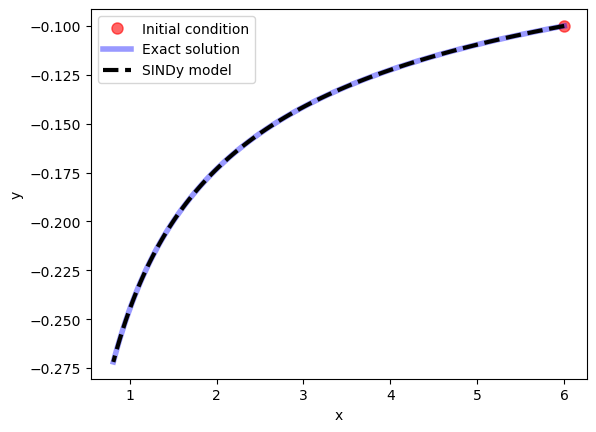

In [10]:
import matplotlib.pyplot as plt
plt.ion()

plt.figure()
plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Note that if the library we had chosen had been inappropriate for the problem at hand (i.e. if the dynamics could not be well-approximated as a sparse linear combination of library functions), then SINDy would have failed to produce a reasonable model. For example, if we solve the same problem, but using sines and cosines as our basis functions, SINDy is unable to find a sparse model for the dynamics:

In [11]:
# Populate the library with trigonometric functions
feature_library = ps.FourierLibrary()

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"],
)
model.fit(X, t=t)
model.print()

(x)' = 0.772 sin(1 x) + 2.097 cos(1 x) + -2.298 sin(1 y) + -3.115 cos(1 y)
(y)' = 1.362 sin(1 y) + -0.222 cos(1 y)


In [12]:
x0, y0, t_test, x_test, y_test = gen_data2()
sim = model.simulate([x0, y0], t=t_test)

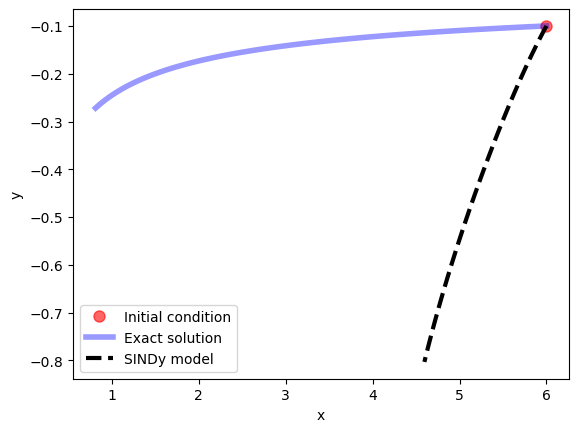

In [13]:
import matplotlib.pyplot as plt
plt.ion()

plt.figure()
plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Back to main idea of the paper

So, how do linear regression and sparsity relate to the SINDy paper? Remember the ordinary differential equation that we’re trying to find:

$$\frac{d}{dt}u(t)=f(u(t))$$

We have samples of $u(t)$ at several times, and nothing else. But if we have $u(t)$, we can easily calculate $\frac{d}{dt}u(t)$ using a numerical method (such as finite differences, or total variation with regularization, as suggested by the authors in the paper). Our goal then is to find the function $f$ that best represents the behavior of the derivative of $u(t)$ over time. One way to represent $f$ is by thinking of it as a linear combination of a set of candidate functions. These candidate functions can be polynomial functions, trigonometric functions, or anything else that might be a reasonable guess for the behavior of the derivatives.

For example, if someone else gives us data that was generated by the Lorenz system without telling us how it was generated, we would be successful in discovering the equations as long as we include low-degree polynomials in our set of candidate functions. That’s because the Lorenz system looks like this:

$$
\begin{align*}
\dot x &= \sigma (y - x) \\
\dot y &= x(\rho - z) - y \\
\dot z &= xy - \beta z
\end{align*}
$$

So, in this case, as long as we include $x$, $y$, $z$, $xy$ and
$xz$ in our set of candidate functions, we should be able to reconstruct the equations from the data.

In the general scenario, we can express the derivatives as a linear combination of candidate functions, as follows:

$$U\prime = \Theta (U)\Xi$$

In the equation above, $U'$ contains the derivatives. For the Lorenz equation, let’s assume that we collected $m$ three-dimensional $(x, y, z)$ samples. Then $U'$ holds the time derivatives at each of those samples, and is of size $m \times 3$.

The matrix $\Theta(U)$ contains $n$ possible candidate functions, and so it’s of size $m \times n$. We can consider any candidate function we’d like for $f$, so we can define this matrix ahead of time. In our Lorenz system scenario, we’ll use low-degree polynomials as our candidate functions: $1, x, y, z, x^2, xy, xz, y^2, yz,$ and $z^2$. So, $n = 10$ in this case.

The matrix $\Xi$ is of size $n \times 3$, and contains the coefficients that multiply the candidate functions. These coefficients are unknown, and it’s our goal to discover them.

Here’s a diagram that demonstrates the structure of our equation for this simple example:

![dimensions](2-dimensions.png)

If you compare this equation with the linear regression one in the previous section, you’ll see that the overall structure is the same. The only difference is that $U'$ and $\Xi$ are now matrices of width $d$, not column vectors. That’s because instead of a single linear regression problem, we have $d$ linear regression problems, one for each dimension. If you split the equation above into $d$ separate equations, each containing a column of $U'$ and the corresponding column of $\Xi$, you’d have $d$ problems with the exact same structure as in the linear regression section. Here’s an illustration of this idea:

![subproblem](3-subproblems.png)

$U$ and $\Theta(U)$ are known, so we need to solve for $\Xi$. We could do that using a direct least-squares method. However, physical equations are typically best represented by just a few terms, so we need $\Xi$ to be sparse. We may consider dozens of different candidate functions in $\Theta(U)$, but in the end, we want only a few to be present in our function $f$. So, in essence, this problem boils down to solving $d$ linear regression problems with sparsity.

LASSO is a popular method for solving linear regression problems while optimizing for a sparse solution. However, the authors of the paper found LASSO to be algorithmically unstable and computationally expensive for very large data sets, so they designed an alternative: the “Sequential Thresholded Least-Squares” algorithm.

## Generation of data and derivatives

In a real-world project, you would set up an experiment, and you would measure your data $U$ from observations. My next blog post will show one way to do this. But in this introductory project, to keep it simple, we’ll generate our data using the Lorenz equations.

Let’s see the code that generates $U$:

In [2]:
# Constants used in the Sequential Thresholded Least-Squares algorithm.
THRESHOLD = 0.025
MAX_ITERATIONS = 10

# The parameters of the Lorenz equation.
SIGMA = 10
RHO = 28
BETA = 8 / 3

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
from typing import Tuple

def lorenz(_: float, u: np.ndarray, sigma: float, rho: float,
           beta: float) -> np.ndarray:
    """Returns a list containing the three functions of the Lorenz equation.

    The Lorenz equations have constant coefficients (that don't depend on t),
    but we still receive t as the first parameter because that's how the
    integrator works.
    """
    x = u[0]
    y = u[1]
    z = u[2]
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z

    return np.hstack((dx_dt, dy_dt, dz_dt))


def generate_data() -> Tuple[np.ndarray, np.ndarray]:
    """Simulates observed data u with the help of an integrator for the Lorenz
    equations.
    """
    t0 = 0.001
    dt = 0.001
    tmax = 100
    n = int(tmax / dt)

    # Step 1: Generate data u.
    u0 = np.array([-8, 8, 27])
    t = np.linspace(start=t0, stop=tmax, num=n)
    result = solve_ivp(fun=lorenz,
                       t_span=(t0, tmax),
                       y0=u0,
                       t_eval=t,
                       args=(SIGMA, RHO, BETA))
    u = result.y.T

    return (u, t)

In [5]:
(u, t) = generate_data()

Here, we use SciPy’s `solve_ivp` function to get the Lorenz solution with initial value `u0`. We need to tell the `solve_ivp` function the timesteps of our trajectory, which we store in variable `t`. In this case, the length of `t` determines the length of the trajectory returned by `solve_ivp`. We also need to specify the parameters of the Lorenz system, which we define elsewhere to be $\sigma = 10$, $\rho=28$, and $\beta = 8/3$.

We now have an array of three-dimensional values that represent a portion of a trajectory in the Lorenz system. But remember that we don’t need the actual data samples $U$, we need their derivatives $U'$. There are many methods to calculate the derivatives of a function numerically. The authors of the paper suggest using total variation derivatives with regularization, because it’s more effective than simpler methods at keeping the noise to a minimum. Both total variation derivatives with regularization and the much simpler finite differences method,  for this simple problem, yields the same results. Therefore, we will use finite differences:

In [14]:
def calculate_finite_difference_derivatives(u: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Calculates the derivatives of u using finite differences with numpy.gradient.

    Args:
        u (np.ndarray): The array of values whose derivatives are to be calculated.
        t (np.ndarray): The array of time points corresponding to the values in u.

    Returns:
        np.ndarray: The array of calculated derivatives.
    """
    print("Using finite difference derivatives with numpy.gradient.")
    # Calculate the derivative using numpy.gradient
    uprime = np.gradient(u, t, axis=0)
    
    return uprime

In [15]:
Uprime = calculate_finite_difference_derivatives(u, t)

Using finite difference derivatives with numpy.gradient.


Using a numerical method to calculate derivatives will always introduce a bit of noise, which is why the equations we discovered aren’t exactly like the original ones, as you saw in the previous section. In this scenario, because we know the equations used to generate the data, we can generate exact derivatives by simply plugging our data into the differential equation. However, we’ll always have some noise in our real-world data and the resulting equations will never be 100% exact.

## Fit model

Let's now create the $\Theta$ library of candidate functions

In [23]:
import numpy as np

def create_library(u: np.ndarray, polynomial_order: int,
                   use_trig: bool) -> np.ndarray:
    """Creates a matrix containing a library of candidate functions.

    For example, if our u depends on x, y, and z, and we specify
    polynomial_order=2 and use_trig=false, our terms would be:
    1, x, y, z, x^2, xy, xz, y^2, yz, z^2.
    """
    (m, n) = u.shape
    theta = np.ones((m, 1))

    # Polynomials of order 1.
    theta = np.hstack((theta, u))

    # Polynomials of order 2.
    if polynomial_order >= 2:
        for i in range(n):
            for j in range(i, n):
                theta = np.hstack((theta, u[:, i:i + 1] * u[:, j:j + 1]))

    # Polynomials of order 3.
    if polynomial_order >= 3:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    theta = np.hstack(
                        (theta, u[:, i:i + 1] * u[:, j:j + 1] * u[:, k:k + 1]))

    # Polynomials of order 4.
    if polynomial_order >= 4:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        theta = np.hstack(
                            (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                             u[:, k:k + 1] * u[:, l:l + 1]))

    # Polynomials of order 5.
    if polynomial_order >= 5:
        for i in range(n):
            for j in range(i, n):
                for k in range(j, n):
                    for l in range(k, n):
                        for m in range(l, n):
                            theta = np.hstack(
                                (theta, u[:, i:i + 1] * u[:, j:j + 1] *
                                 u[:, k:k + 1] * u[:, l:l + 1] * u[:, m:m + 1]))

    if use_trig:
        for i in range(1, 11):
            theta = np.hstack((theta, np.sin(i * u), np.cos(i * u)))

    return theta

This function takes the data $U$ as a parameter, and uses it to calculate the numerical values for each of the candidate functions considered. In our scenario, we want to consider candidate polynomial functions up to order 2, so the `polynomial_order` parameter is set to 2. And we don’t want to consider trigonometric candidate functions, so the `use_trig` parameter is set to `False`.

In [24]:
# Constants used in the calculation of the Theta matrix of potential terms.
POLYNOMIAL_ORDER = 2
USE_TRIG = False

theta = create_library(u, POLYNOMIAL_ORDER, USE_TRIG)


Sequential Thresholded Least-Squares algorithm:

In [21]:
import numpy as np

def calculate_regression(theta: np.ndarray, uprime: np.ndarray,
                         threshold: float, max_iterations: int) -> np.ndarray:
    """Finds a xi matrix that fits theta * xi = uprime, using the sequential
    thresholded least-squares algorithm, which is a regression algorithm that
    promotes sparsity.

    The authors of the SINDy paper designed this algorithm as an alternative
    to LASSO, because they found LASSO to be algorithmically unstable, and
    computationally expensive for very large data sets.
    """
    # Solve theta * xi = uprime in the least-squares sense.
    xi = np.linalg.lstsq(theta, uprime, rcond=None)[0]
    n = xi.shape[1]

    # Add sparsity.
    for _ in range(max_iterations):
        small_indices = np.abs(xi) < threshold
        xi[small_indices] = 0
        for j in range(n):
            big_indices = np.logical_not(small_indices[:, j])
            xi[big_indices, j] = np.linalg.lstsq(theta[:, big_indices],
                                                 uprime[:, j],
                                                 rcond=None)[0]

    return xi

In the code above, the `theta` input parameter contains the $\Theta$ matrix of candidate functions, and the uprime input parameter contains the $U'$ matrix with derivatives — these are known ahead of time. The output of this function is the $\Xi$ matrix, which is initially unknown. The `threshold` and `max_iterations` input parameters help us fine-tune the Sequential Threasholded Least-Squares algorithm, as we’ll see soon.


The first operation in this algorithm is to calculate a least-squares solution to the equation using a direct method, which is a great starting point:

In [27]:
xi = np.linalg.lstsq(theta, Uprime, rcond=None)[0]
print(xi)

[[-1.55532216e-02 -8.30092479e-02 -3.75189629e-01]
 [-9.95931046e+00  2.76556092e+01 -2.36380368e-03]
 [ 9.97191480e+00 -8.50288233e-01  3.16696386e-03]
 [ 1.53011196e-03  9.60832279e-03 -2.61005862e+00]
 [ 1.76063938e-04  1.05500926e-04  1.01744253e-02]
 [-2.07122048e-04  2.94951425e-04  9.91509536e-01]
 [-1.33273727e-03 -9.89062223e-01  1.86258361e-05]
 [ 7.97423644e-05 -3.13833086e-04  8.56372784e-04]
 [ 1.01633347e-03 -3.38802659e-03 -7.46635580e-05]
 [-4.61585636e-05 -2.15240315e-04 -1.88624525e-03]]


Above is one potential result for this operation. Remember that the $\Xi$ matrix in our scenario has shape $10 \times 3$, because we’re considering 10 candidate functions and have 3 dimensions.

This matrix solves the equation, but as you can see, it’s not sparse. The role of the `for` loop that follows is to introduce sparsity to the matrix, while compromising as little as possible on the accuracy of the solution. The code first identifies all the matrix locations with coefficients smaller than the threshold passed as a parameter, and sets those coefficients to zero:

```python
for _ in range(max_iterations):
    small_indices = np.abs(xi) < threshold
    xi[small_indices] = 0
    for j in range(n):
        big_indices = np.logical_not(small_indices[:, j])
        xi[big_indices, j] = np.linalg.lstsq(theta[:, big_indices],
                                                uprime[:, j],
                                                rcond=None)[0]
```

Then, it solves the least-squares problem considering only the remaining non-zero coefficients. However, because we may have a different number of non-zero coefficients in each column of $\Xi$, we need to break the problem into $d$ separate linear regression problems, one for each column of $\Xi$ and corresponding column of $U'$. We show this idea in the illustration at the end of the previous section.

Let’s look at what the $\Xi$ matrix looks like after one iteration of the outer loop, with threshold value 0.025:

![Xi](11-xi.png)

The matrix is much sparser now. We repeat this procedure 9 more times because we set `max_iterations`` to 10, and by the end, we have the following matrix:


![Xi](12-xi.png)

And we’re done — we discovered a sparse $\Xi$ matrix! We can now use it to write down the equation of the system, rounded to two decimal places:

$$
\begin{align*}
\dot x &= 10 y - 10 x\\
\dot y &= 27.81x - 0.99 xz - 9.6y \\
\dot z &= xy - 2.67z
\end{align*}
$$

As you can see, the system discovered by this algorithm is very similar to the Lorenz system with parameters $\sima =10$, $\rho=28$, and $\beta=8/3$. These are the parameter values I used in the generation of the input data, as we’ll see in the next section.

$$
\begin{align*}
\dot x &= 10 (y - x)\\
\dot y &= x (28 - z) - y \\
\dot z &= xy - 8/3z
\end{align*}
$$

The small differences between the predicted and actual coefficients are due to noise in the calculation of the derivatives. We’ll also come back to this in the next section.

Let’s now take a look at the main function in this file. As you can see, it has two steps: it creates the $\Theta$
library of candidate functions, and it uses the Sequential Thresholded Least-Squares algorithm to discover $\Xi$.

In [29]:
theta = create_library(u, POLYNOMIAL_ORDER, USE_TRIG)
xi = calculate_regression(theta, Uprime, THRESHOLD, MAX_ITERATIONS)

In [30]:
print(xi)

[[  0.           0.           0.        ]
 [-10.00449518  27.80496577   0.        ]
 [ 10.00429024  -0.95767769   0.        ]
 [  0.           0.          -2.66700595]
 [  0.           0.           0.        ]
 [  0.           0.           0.99924596]
 [  0.          -0.99347666   0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]]


Up until now, we explored the implementation of the basic ideas of SINDy, to help you understand its nuts and bolts. However, now that the PySINDy package is available, it’s much easier to just use that instead.

In [6]:
import pysindy as ps
# pylint: disable=unused-import
from pysindy.differentiation import FiniteDifference, SINDyDerivative
from pysindy.optimizers import STLSQ
import logging

def fit(u: np.ndarray, t: np.ndarray) -> ps.SINDy:
    """Uses PySINDy to find the equation that best fits the data u.
    """
    optimizer = STLSQ(threshold=THRESHOLD, max_iter=MAX_ITERATIONS)

    # Total variation derivatives with regularization.
    # differentiation_method = SINDyDerivative(
    #     derivative_kws={"trend_filtered", 0, 1e-2})

    # Finite difference derivatives.
    differentiation_method = FiniteDifference()

    model = ps.SINDy(optimizer=optimizer,
                     differentiation_method=differentiation_method,
                     feature_names=["x", "y", "z"],
                     discrete_time=False)
    model.fit(u, t=t)
    model.print()
    logging.info("xi: %s", model.coefficients().T)

    return model


In [7]:
model = fit(u, t)

(x)' = -10.005 x + 10.004 y
(y)' = 27.805 x + -0.958 y + -0.993 x z
(z)' = -2.667 z + 0.999 x y


## Prediction

Let’s think about what it means to make a prediction in this scenario. In our `fit` code we discovered a system of ordinary differential equations based on our data. Therefore, if we’re given an initial condition, we should be able to integrate the differential equation we discovered and get a trajectory that predicts future values. We’ve already seen how to integrate an ordinal differential equation using the `solve_ivp` function, when we generated our data $U$ using the Lorenz equation. We’ll use the same technique here, except this time we want to integrate the differential equation we discovered:

$$U' = \Theta(U)\Xi$$

We generated $U$, calculated $U'$ using finite differences, generated $\Theta$, and computed $\Xi$ using Sequential Thresholded Least-Squares. We have all the pieces of the puzzle, and are now ready to understand the code that integrates the equation we discovered.

In [8]:
"""Utilities related to graphing."""

import matplotlib.pyplot as plt
import numpy as np


def style_axis(axis):
    """Styles a graph's x, y, or z axis."""
    # pylint: disable=protected-access
    axis._axinfo["grid"]["color"] = "#dddddd"
    axis._axinfo["grid"]["linewidth"] = 0.4
    axis._axinfo["tick"]["linewidth"][True] = 0.4
    axis._axinfo["tick"]["linewidth"][False] = 0.4
    axis.set_pane_color((0.98, 0.98, 0.98, 1.0))
    axis.line.set_color("#bbbbbb")
    axis.label.set_color("#333333")
    pass


def style_axis3d(axis3d):
    """Styles a 3D graph."""
    axis3d.set_xlabel("x")
    axis3d.set_ylabel("y")
    axis3d.set_zlabel("z")
    axis3d.tick_params(axis="x", colors="#666666")
    axis3d.tick_params(axis="y", colors="#666666")
    axis3d.tick_params(axis="z", colors="#666666")
    style_axis(axis3d.w_xaxis)
    style_axis(axis3d.w_yaxis)
    style_axis(axis3d.w_zaxis)
    axis3d.set_title(axis3d.get_title(), fontdict={"color": "#333333"})


def graph_results(u: np.ndarray, u_approximation: np.ndarray) -> None:
    """Graphs two 3D trajectories side-by-side."""
    sample_count = 20000
    orange = "#EF6C00"

    fig = plt.figure(figsize=plt.figaspect(0.5))

    # Graph trajectory from the true model.
    axis3d = fig.add_subplot(1, 2, 1, projection="3d")
    x = u[0:sample_count, 0]
    y = u[0:sample_count, 1]
    z = u[0:sample_count, 2]
    axis3d.plot3D(x, y, z, orange, linewidth=0.4)
    axis3d.set_title("Original trajectory")
    style_axis3d(axis3d)

    # Graph trajectory computed from model discovered by SINDy.
    axis3d = fig.add_subplot(1, 2, 2, projection="3d")
    x = u_approximation[0:sample_count, 0]
    y = u_approximation[0:sample_count, 1]
    z = u_approximation[0:sample_count, 2]
    axis3d.plot3D(x, y, z, orange, linewidth=0.4)
    axis3d.set_title("SINDy approximation")
    style_axis3d(axis3d)

    plt.show()

### Compute trajectory

Calculates the trajectory of the model discovered by SINDy.

Given an initial value for $U$, we call the lorenz_approximation function to calculate the corresponding du/dt. Then, using a numerical method, `solve_ivp` uses that derivative to calculate the next value of $U$, using the $\Xi$ matrix discovered by SINDy. This process repeats, until we have all values of the $U$ trajectory.

In [9]:
def compute_trajectory(u0: np.ndarray, model: ps.SINDy) -> np.ndarray:
    """Calculates the trajectory using the model discovered by SINDy.
    """
    t0 = 0.001
    dt = 0.001
    tmax = 100
    n = int(tmax / dt + 1)
    t_eval = np.linspace(start=t0, stop=tmax, num=n)

    u_approximation = model.simulate(u0, t_eval)

    return u_approximation

/var/folders/6k/lmrc2s553fq0vn7c57__f37r0000gn/T/ipykernel_42491/4121611849.py:28: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  style_axis(axis3d.w_xaxis)
/var/folders/6k/lmrc2s553fq0vn7c57__f37r0000gn/T/ipykernel_42491/4121611849.py:29: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  style_axis(axis3d.w_yaxis)
/var/folders/6k/lmrc2s553fq0vn7c57__f37r0000gn/T/ipykernel_42491/4121611849.py:30: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  style_axis(axis3d.w_zaxis)


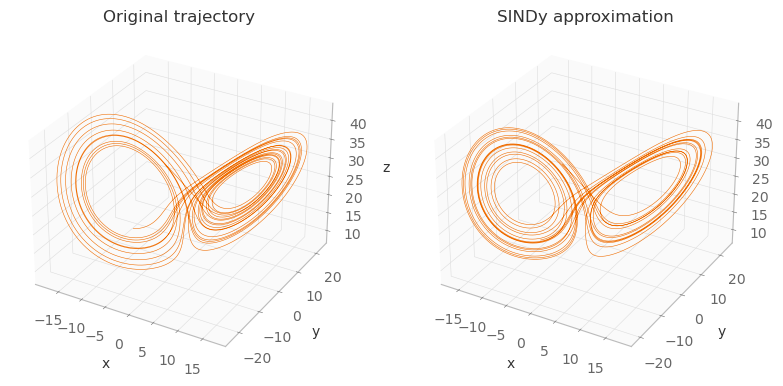

In [10]:
u0 = np.array([-8, 8, 27])
u_approximation = compute_trajectory(u0, model)
graph_results(u, u_approximation)

As you can see, the images aren’t exactly the same (because the equations discovered by SINDy aren’t exactly the same as the originals), but they’re very close. In the derivative calculation step, if instead of finite differences we had used exact derivatives, these two images would be exactly the same.